# 1. Make Necessary Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, r2_score, mean_squared_error
from sklearn.utils.multiclass import unique_labels

# 2. Load data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 3. Understand data

In [3]:
# print 5 rows of training dataset
train_df.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [4]:
# print datatype of colums
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38932 entries, 0 to 38931
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User_ID       38932 non-null  object
 1   Description   38932 non-null  object
 2   Browser_Used  38932 non-null  object
 3   Device_Used   38932 non-null  object
 4   Is_Response   38932 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB


In [5]:
# display count, unique count and most frequent value for each column

train_df.describe().transpose()

,count,unique,top,freq
User_ID,38932,38932,id10326,1
Description,38932,38932,The room was kind of clean but had a VERY stro...,1
Browser_Used,38932,11,Firefox,7367
Device_Used,38932,3,Desktop,15026
Is_Response,38932,2,happy,26521


Happy: 68.12133977190999%
Not Happy: 31.878660228090006%


<Axes: xlabel='Is_Response', ylabel='count'>

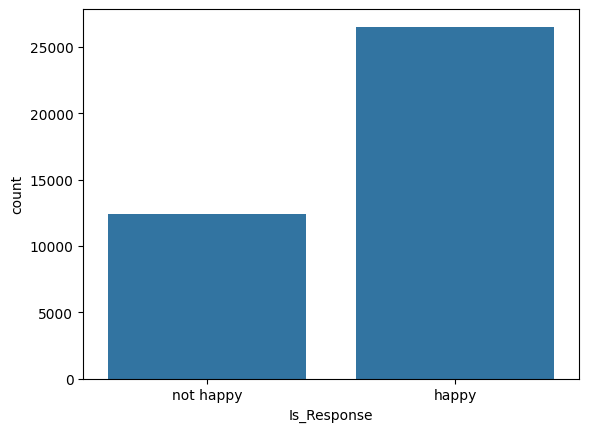

In [6]:
# display percentage of distrubution of data between the two target classes

happy_percent = train_df['Is_Response'].value_counts()['happy']/train_df['Is_Response'].count()
not_happy_percent = train_df['Is_Response'].value_counts()['not happy']/train_df['Is_Response'].count()

print(f'Happy: {happy_percent*100}%')
print(f'Not Happy: {not_happy_percent*100}%')


sns.countplot(x=train_df['Is_Response'])

## upsample imbalance target

In [7]:
train_df.shape

(38932, 5)

In [8]:
train_df['Is_Response'].value_counts()

Is_Response
happy        26521
not happy    12411
Name: count, dtype: int64

In [9]:
from sklearn.utils import resample
# resample the data to balance the target classes
#create two different dataframe
happy = train_df[train_df['Is_Response'] == 'happy']
not_happy = train_df[train_df['Is_Response'] == 'not happy']

# upsample minority class
df_minority_upsampled = resample(not_happy,
                                 replace=True,    # sample with replacement
                                 n_samples= 26521, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
train_df = pd.concat([df_minority_upsampled, happy])

In [10]:
train_df.shape

(53042, 5)

In [11]:
train_df['Is_Response'].value_counts()

Is_Response
not happy    26521
happy        26521
Name: count, dtype: int64

# 4. Preprocess Data
<p> Only Taking description column for fitting the model as other columsn such as userid, browser used and device used irrelevant for this taks. So dropping all unnecessary cols.<br>

Also, we will be cleaning text by removing unncessary char, num and whitspaces.
</p>

In [12]:
train_df.drop(columns=['User_ID','Browser_Used', 'Device_Used'], inplace=True)

In [13]:
train_df.replace({'Is_Response':'not happy'},0, inplace=True)
train_df.replace({'Is_Response':'happy'},1, inplace=True)


/tmp/ipykernel_3518862/827162816.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.replace({'Is_Response':'happy'},1, inplace=True)


In [14]:
train_df.head()

,Description,Is_Response
22859,Graduation weekend--we paid for and reserved o...,0
2700,We had to move rooms two time in less than -- ...,0
16787,The first room we were put in had a faucet tha...,0
16106,"I was at this hotel for a conference, so it's ...",0
37519,"A musty, old unrenovated hotel, not up to the ...",0


In [16]:
# function to clean the given text from unwanted word and chars
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
stop = stopwords.words('english')

def text_clean(text):
  text = text.lower() # lower cass all words
  text = re.sub('\[.*?\]','',text) # replace regex pattern with provided string in text, replace [..]
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # replace all s except punctuated one
  text = re.sub('\w*\d\w*','',text) # replace all alphanumeric words
  text = re.sub('[''""_]','',text) # repalce '' "" _ with space
  text = re.sub('\n','',text) # replace line brk

  text = text.split(" ")
  # remove stop words from text
  text = [x for x in text if x not in stop]
  # remove empty tokens
  text = [x for x in text if len(x) > 0]

  text = " ".join(text)
  return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abhishek/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
def decontract_text(text):

  text = re.sub(r"won\'t", " will not", text)
  text = re.sub(r"won\’t", " will not", text)
  text = re.sub(r"can\’t", " can not", text)
  text = re.sub(r"can\'t", " can not", text)
  text = re.sub(r"\'t've", " not have", text)
  text = re.sub(r"\'d've", " would have", text)
  text = re.sub(r"\'cause", " because", text)

  text = re.sub(r"n\'t"," not", text)
  text = re.sub(r"\'re"," are",text)
  text = re.sub(r"\'s"," is", text)
  text = re.sub(r"\'d"," would",text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'t"," not", text)
  text = re.sub(r"\'ve", " have",text)
  text = re.sub(r"\'m"," am", text)

  text = re.sub(r"n\’t", " not", text)
  text = re.sub(r"\’re", " are", text)
  text = re.sub(r"\’s", " is", text)
  text = re.sub(r"\’d", " would", text)
  text = re.sub(r"\’ll", " will", text)
  text = re.sub(r"\’t", " not", text)
  text = re.sub(r"\’ve", " have", text)
  text = re.sub(r"\’m", " am", text)

  return text


In [18]:
train_df['cleaned_desc'] = train_df['Description'].apply(lambda x: decontract_text(x))
train_df["cleaned_desc"] = train_df['cleaned_desc'].apply(lambda x: text_clean(x))

In [19]:
print('Original: \n', train_df['Description'][0])
print('cleanded: \n', train_df['cleaned_desc'][0])

Original: 
 The room was kind of clean but had a VERY strong smell of dogs. Generally below average but ok for a overnight stay if you're not too fussy. Would consider staying again if the price was right. Breakfast was free and just about better than nothing.
cleanded: 
 room kind clean strong smell dogs generally average ok overnight stay fussy would consider staying price right breakfast free better nothing


# 5. Split 80-20 train-test data

In [20]:
X = train_df['cleaned_desc']
y = train_df['Is_Response']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print(f'x_train: {len(X_train)}, x_test: {len(X_test)}, y_train: {len(y_train)}, y_test: {len(y_test)}')

x_train: 42433, x_test: 10609, y_train: 42433, y_test: 10609


# Model selection
<p> Using tfidf vectorization for vectorization of cleaned description. <br>
Using pipeline to combine vectorization and classifier together
</p>

In [21]:
tfidf_vec = TfidfVectorizer()

clf = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')
clf = GridSearchCV(clf,{'C':[0.001,0.01,0.1,1,10]},cv=5)

model = Pipeline([('vectorizer', tfidf_vec),('classifier',clf)])

In [22]:
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=LogisticRegression(class_weight='balanced',
                                                           max_iter=1000),
                              param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}))])

In [23]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [30,50,100,1000]
}

random = RandomForestClassifier(n_estimators=100, random_state=42)
random = GridSearchCV(random, param_grid, cv=5, scoring='neg_mean_squared_error')

random_model = Pipeline([('vectorizer',tfidf_vec),('classifier',random)])

In [ ]:
# random_model.fit(X_train,y_train)

In [24]:
# neural network
from sklearn.neural_network import MLPClassifier

neural_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

neural_model = Pipeline([('vectorizer',tfidf_vec),('classifier',neural_clf)])

In [ ]:
# neural_model.fit(X_train,y_train)

# Evaluation

In [25]:
y_pred = model.predict(X_test)
print('testing: ')
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'Precision: {precision_score(y_pred, y_test, average="weighted")}')
print(f'Recall: {recall_score(y_pred, y_test, average="weighted")}')
print()
print('training: ')
y_pred_train = model.predict(X_train)
print(f'Accuracy: {accuracy_score(y_pred_train, y_train)}')
print(f'Precision: {precision_score(y_pred_train, y_train, average="weighted")}')
print(f'Recall: {recall_score(y_pred_train, y_train, average="weighted")}')

testing: 
Accuracy: 0.9137524743142614
Precision: 0.9143415459264588
Recall: 0.9137524743142614

training: 
Accuracy: 0.9680437395423374
Precision: 0.9681282310236095
Recall: 0.9680437395423374


In [ ]:
# y_pred = random_model.predict(X_test)

# print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
# print(f'Precision: {precision_score(y_pred, y_test, average="weighted")}')
# print(f'Recall: {recall_score(y_pred, y_test, average="weighted")}')

In [ ]:
# y_pred = neural_model.predict(X_test)

# print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
# print(f'Precision: {precision_score(y_pred, y_test, average="weighted")}')
# print(f'Recall: {recall_score(y_pred, y_test, average="weighted")}')

In [26]:
model.predict(['food was bad'])

array([0])

In [27]:
model.predict(['food was not so great'])

array([1])

In [28]:
model.predict(['unhygienic place'])

array([0])

In [29]:
model.predict(['unhygienic'])


array([1])

In [30]:
model.predict(['food was not good at all'])

array([0])

In [31]:
model.predict(['room was dirty'])

array([0])

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras import layers

# model = Sequential()
# model.add(layers.Embedding(5000, 40, input_length=200))
# model.add(layers.BatchNormalization())
# model.add(layers.Bidirectional(layers.LSTM(15,dropout=0.6)))
# model.add(layers.Dense(3,activation='softmax'))

In [ ]:
# model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy']) #compile model
# history2 = model.fit(X_train, y_train, epochs=50,validation_split=0.2) #training
# _, accuracy = model.evaluate(X_test,y_test)    #testing
# print("Model accuracy: %.2f"% (accuracy*100))
# predictions = model.predict(X_test)


# Save model

In [32]:
import pickle as pk

pk.dump(model, open('logistics_regression_model.pkl', 'wb'))